# Crop type mapping from multitemporal Quad_PolSAR change detection: Neural network training
In this notebook, Neural networks (NN) are trained using Keras for the crop type classification application presented in the paper: Multi-Temporal Polarimetric SAR (MT-PolSAR) Change Detection For Crop Monitoring And Crop Type Classification (under review)([link text](https://github.com/crisjosil/MT-PolSAR-Change-Detection-For-Crop-Monitoring-And-Classification)).  

Given that the data available for training is highly imbalanced, we use a weighted categorical cross entropy loss function to train the NN. The final model uses three dense layers with relu activation function and Nadam optimiser with 5e-4 learning rate.

Since the purpose was to compare classification performance between using the change matrix proposed in the paper and the traditional use of PolSAR time series, we train separate models for each case. The output of the model is the prediction of crop types, that can either be 10 classes when classifying the cereal crops individually (i.e. Barley, oats,wheat,etc) or 6 classes, when grouping the cereal into a single class.

Please check the other notebooks in the repository to see the test and use of the models for prediction on the whole dataset.

# Preliminars: Imports, load datasets

In [ ]:
!pip install fiona
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 14.8MB 204kB/s 
Mounted at /content/drive


In [ ]:
# python
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt 
from collections import Counter
import fiona
import os
from itertools import product
from __future__ import print_function
from functools import partial
import pandas as pd
import itertools
from google.colab import files
from pickle import dump
#sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler    
from sklearn.preprocessing import Normalizer 
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight

# imblearn
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import keras.backend as K
# Tensor flow
import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)
tf.test.gpu_device_name()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

2.4.1


'/device:GPU:0'

### Read datasets of polarimetric time series. 
Classification based on this dataset is used as baseline

In [ ]:
N_images=7
N_features=16
# Name to save the model
model_name_list=['PolSAR_red_V10_Nadam']

In [ ]:
print("Reading PolSAR features test datasets ...")
root="/content/drive/My Drive/Datasets/AgriSAR_Paper2/Final_datasets/PolSAR_F/V10/"
layer_name = "y_train.npy"
y_train0=np.load(root + layer_name,  allow_pickle=True)
layer_name = "y_val.npy"
y_train0_lev2=np.load(root + layer_name,  allow_pickle=True)
layer_name = "y_test.npy"
y_test0=np.load(root + layer_name,  allow_pickle=True)
print(Counter(y_train0))

layer_name = "X_train.npy"
X_train0=np.load(root + layer_name,  allow_pickle=True)
print("Done")
layer_name = "X_val.npy"
X_train0_lev2=np.load(root + layer_name,  allow_pickle=True)
print("Reading testing labels ...")
layer_name = "X_test.npy"
X_test0=np.load(root + layer_name,  allow_pickle=True)
print("Done")

Reading PolSAR features test datasets ...
Counter({9.0: 347355, 2.0: 260715, 4.0: 155104, 7.0: 94766, 5.0: 67502, 0.0: 66061, 3.0: 63305, 6.0: 57005, 1.0: 34693, 8.0: 31703})
Done
Reading testing labels ...
Done


### Scale data with MinMaxScaler() prior training the Neural Network

In [ ]:
print("Scaling ...")     
sc = MinMaxScaler()   
X_train = sc.fit_transform(X_train0)
X_train_lev2 = sc.transform(X_train0_lev2)
X_test = sc.transform(X_test0)

print("Reshaping as 2d images ...")
X_train_2d=X_train.reshape(X_train.shape[0],N_images,N_features,1)
X_train_lev2_2d=X_train_lev2.reshape(X_train_lev2.shape[0],N_images,N_features,1)
X_test_2d=X_test.reshape(X_test.shape[0],N_images,N_features,1)
print("Training array shape: "+str(X_train_2d.shape))
print("Validation array shape: "+str(X_train_lev2_2d.shape))
print("Test array shape: "+str(X_test_2d.shape))

Scaling ...
Reshaping as 2d images ...
Training array shape: (1178209, 7, 16, 1)
Validation array shape: (280545, 7, 16, 1)
Test array shape: (326978, 7, 16, 1)


#### Show few random examples of PolSAR features organised as 2d images: 
Every 2d array is a pixel.
Each columns is a PolSAR feature and every row is a date

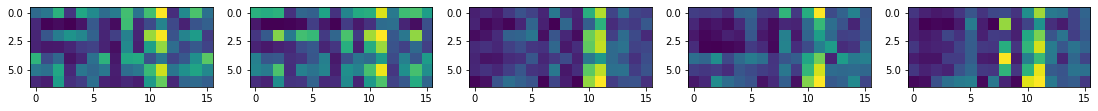

In [ ]:
fig,(ax,ax1,ax2,ax3,ax4)=plt.subplots(nrows=1,ncols=5,figsize=(19,8))
ax.imshow(X_train_2d[0,:,:,0])
ax1.imshow(X_train_2d[100000,:,:,0])
ax2.imshow(X_train_2d[200000,:,:,0])
ax3.imshow(X_train_2d[300000,:,:,0])
ax4.imshow(X_train_2d[400000,:,:,0])

In [ ]:
# name to save model
#model_name_list=['PolSAR_V8_Nadam']

### Read change matrices

In [ ]:
model_name_list=['CM_diag_V7_Nadam']

In [ ]:
# # Change matrices
root="/content/drive/My Drive/Datasets/AgriSAR_Paper2/Final_datasets/CM/V7/"
#var='_.npy'
var='_with_diag.npy'#
layer_name = "y_train"+var
y_train_CM0=np.load(root + layer_name,  allow_pickle=True)
layer_name = "y_test"+var
y_test_CM0=np.load(root + layer_name,  allow_pickle=True)
# layer_name = "y_val"+var
# y_train_CM0_lev2=np.load(root + layer_name,  allow_pickle=True)

print("Reading training data ...")
layer_name = "X_train"+var
X_train_CM0=np.load(root + layer_name,  allow_pickle=True)
X_train_CM0 = np.nan_to_num(X_train_CM0)
print("Reading testing data ...")
layer_name = "X_test"+var
X_test_CM0=np.load(root + layer_name,  allow_pickle=True)
X_test_CM0 = np.nan_to_num(X_test_CM0)
#print("Reading validation data ...")
# layer_name = "X_val"+var
# X_train_CM0_lev2=np.load(root + layer_name,  allow_pickle=True)
# X_train_CM0_lev2 = np.nan_to_num(X_train_CM0_lev2)
print("Done")

Reading training data ...
Reading testing data ...
Done


#### Plot some change matrices without scaling

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reshaping as 2d images ...
Training array shape: (1176829, 7, 7, 3)
Test array shape: (317634, 7, 7, 3)


Text(0.5, 1.0, 'Crop type: 9.0')

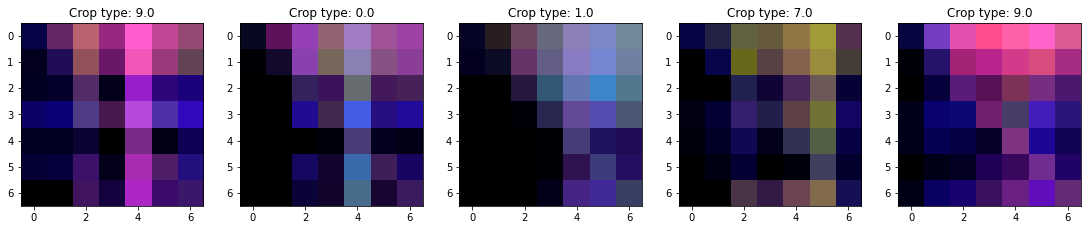

In [ ]:
print("Reshaping as 2d images ...")
X_train_CM0_2d=X_train_CM0.reshape(X_train_CM0.shape[0],N_images,N_images,3)
#X_train_CM0_lev2_2d=X_train_CM0_lev2.reshape(X_train_CM0_lev2.shape[0],N_images,N_images,3)
X_test_CM0_2d=X_test_CM0.reshape(X_test_CM0.shape[0],N_images,N_images,3)
print("Training array shape: "+str(X_train_CM0_2d.shape))
#print("Validation array shape: "+str(X_train_CM_lev2_2d.shape))
print("Test array shape: "+str(X_test_CM0_2d.shape))
#X_train_Tr5 = tf.keras.utils.normalize(X_train_Tr5, axis=1)
#X_test_Ts5 = tf.keras.utils.normalize(X_test_Ts5, axis=1)

fig,(ax,ax1,ax2,ax3,ax4)=plt.subplots(nrows=1,ncols=5,figsize=(19,8))
ax.imshow(X_train_CM0_2d[50000,:,:,:]*5)
ax.set_title("Crop type: "+str(y_train_CM0[50000]))
ax1.imshow(X_train_CM0_2d[100000,:,:,:]*5)
ax1.set_title("Crop type: "+str(y_train_CM0[100000]))
ax2.imshow(X_train_CM0_2d[250000,:,:,:]*5)
ax2.set_title("Crop type: "+str(y_train_CM0[250000]))
ax3.imshow(X_train_CM0_2d[370000,:,:,:]*5)
ax3.set_title("Crop type: "+str(y_train_CM0[370000]))
ax4.imshow(X_train_CM0_2d[800000,:,:,:]*5)
ax4.set_title("Crop type: "+str(y_train_CM0[800000]))

#### Scale and plot some change matrices with scaling
Note: Because of the min_max scaling, the change matrix no longer shows physical scattering mechanisms

In [ ]:
print("Scaling ...")     
# without normalizing change matrix   
# X_train_CM = X_train_CM0
# X_train_CM_lev2 = X_train_CM0_lev2
# X_test_CM = X_test_CM0

sc = MinMaxScaler()
#sc = StandardScaler() 
#sc = Normalizer() 
X_train_CM = sc.fit_transform(X_train_CM0)
#X_train_CM_lev2 = sc.transform(X_train_CM0_lev2) 
X_test_CM = sc.transform(X_test_CM0)
# save the scaler
dump(sc, open('scaler.pkl', 'wb'))

print("Reshaping as 2d images ...")
X_train_CM_2d=X_train_CM.reshape(X_train_CM.shape[0],N_images,N_images,3)
#X_train_CM_lev2_2d=X_train_CM_lev2.reshape(X_train_CM_lev2.shape[0],N_images,N_images,3)
X_test_CM_2d=X_test_CM.reshape(X_test_CM.shape[0],N_images,N_images,3)
print("Training array shape: "+str(X_train_CM_2d.shape))
#print("Validation array shape: "+str(X_train_CM_lev2_2d.shape))
print("Test array shape: "+str(X_test_CM_2d.shape))
#X_train_Tr5 = tf.keras.utils.normalize(X_train_Tr5, axis=1)
#X_test_Ts5 = tf.keras.utils.normalize(X_test_Ts5, axis=1)

Scaling ...
Reshaping as 2d images ...
Training array shape: (1176829, 7, 7, 3)
Test array shape: (317634, 7, 7, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


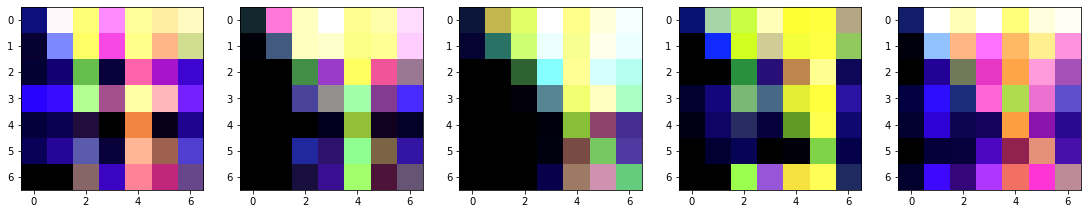

In [ ]:
fig,(ax,ax1,ax2,ax3,ax4)=plt.subplots(nrows=1,ncols=5,figsize=(19,8))
ax.imshow(X_train_CM_2d[50000,:,:,:]*5)
#ax.set_title("Crop type: "+str(y_train0[646782]))
ax1.imshow(X_train_CM_2d[100000,:,:,:]*5)
#ax1.set_title("Crop type: "+str(y_train0[100000]))
ax2.imshow(X_train_CM_2d[250000,:,:,:]*5)
#ax2.set_title("Crop type: "+str(y_train0[250000]))
ax3.imshow(X_train_CM_2d[370000,:,:,:]*5)
#ax3.set_title("Crop type: "+str(y_train0[370000]))
ax4.imshow(X_train_CM_2d[800000,:,:,:]*5)
#ax4.set_title("Crop type: "+str(y_train0[800000]))

In [ ]:
# fig,(ax,ax1,ax2,ax3,ax4)=plt.subplots(nrows=1,ncols=5,figsize=(19,8))
# ax.imshow(X_train_CM_lev2_2d[0,:,:,:]*5)
# ax.set_title("Crop type: "+str(y_train_CM0[0]))
# ax1.imshow(X_train_CM_lev2_2d[100000,:,:,:]*5)
# ax1.set_title("Crop type: "+str(y_train_CM0[10000]))
# ax2.imshow(X_train_CM_lev2_2d[25000,:,:,:]*5)
# ax2.set_title("Crop type: "+str(y_train_CM0[25000]))
# ax3.imshow(X_train_CM_lev2_2d[37000,:,:,:]*5)
# ax3.set_title("Crop type: "+str(y_train_CM0[37000]))
# ax4.imshow(X_train_CM_lev2_2d[-1,:,:,:]*5)
# ax4.set_title("Crop type: "+str(y_train_CM0[-1]))

# Custom Loss function for imbalanced classification


*   Uses weighted categorical cross entropy




### Class and sample_weights

Note that here we give more weights to the classes and samples with lower number of samples represented in the training data

In [ ]:
#y_tr = y_train_CM0 # Enable for CM
y_tr = y_train0 # enable for PolSAR

In [ ]:
# Determine weight of each class according to number of samples
# For train
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_tr),
                                                 y_tr)
class_weight_dict = dict(enumerate(class_weights/class_weights.max())) # normalize the weights to one

sample_weight=np.zeros(y_tr.shape)
for r in np.unique(y_tr):
  sample_weight=np.where(y_tr==r,class_weight_dict[r],sample_weight)

print(np.unique(sample_weight))
print(class_weight_dict)

[0.09126974 0.12160021 0.20439834 0.33453981 0.46966016 0.47990494
 0.50079773 0.5561442  0.91381547 1.        ]
{0: 0.4799049363467099, 1: 0.9138154670971089, 2: 0.12160021479393208, 3: 0.5007977252981597, 4: 0.20439833917887354, 5: 0.4696601582175343, 6: 0.5561441978773792, 7: 0.3345398138572906, 8: 1.0, 9: 0.09126973845201596}


In [ ]:
# Custom loss function with costs
def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.expand_dims(y_pred_max, 1)
    y_pred_max_mat = K.equal(y_pred, y_pred_max)
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):

        final_mask += (K.cast(weights[c_t, c_p],K.floatx()) * K.cast(y_pred_max_mat[:, c_p] ,K.floatx())* K.cast(y_true[:, c_t],K.floatx()))
    return K.categorical_crossentropy(y_pred, y_true) * final_mask

In [ ]:
# Array with weights
w_array = np.ones((10,10))
for i in range(10):
  w_array[:,i]=class_weight_dict[i]
for i in range(10):
  w_array[i,i]=1
w_array

array([[1.        , 0.91381547, 0.12160021, 0.50079773, 0.20439834,
        0.46966016, 0.5561442 , 0.33453981, 1.        , 0.09126974],
       [0.47990494, 1.        , 0.12160021, 0.50079773, 0.20439834,
        0.46966016, 0.5561442 , 0.33453981, 1.        , 0.09126974],
       [0.47990494, 0.91381547, 1.        , 0.50079773, 0.20439834,
        0.46966016, 0.5561442 , 0.33453981, 1.        , 0.09126974],
       [0.47990494, 0.91381547, 0.12160021, 1.        , 0.20439834,
        0.46966016, 0.5561442 , 0.33453981, 1.        , 0.09126974],
       [0.47990494, 0.91381547, 0.12160021, 0.50079773, 1.        ,
        0.46966016, 0.5561442 , 0.33453981, 1.        , 0.09126974],
       [0.47990494, 0.91381547, 0.12160021, 0.50079773, 0.20439834,
        1.        , 0.5561442 , 0.33453981, 1.        , 0.09126974],
       [0.47990494, 0.91381547, 0.12160021, 0.50079773, 0.20439834,
        0.46966016, 1.        , 0.33453981, 1.        , 0.09126974],
       [0.47990494, 0.91381547, 0.1216002

In [ ]:
ncce = partial(w_categorical_crossentropy, weights=w_array)
ncce.__name__ ='w_categorical_crossentropy'

# Custom metrics and callbacks

*   f1_macro
*   Balanced accuracy
*   Normal accuracy, just for information


*   Callback to save the model which achieves best balanced accuracy
*   Callback to adjust learning rate: case-specific  







In [ ]:
import sklearn.metrics as sklm
class My_Metrics(tf.keras.callbacks.Callback):
    def __init__(self, X_validation, y_validation, save_model_name, logs={}):
        #self.confusion = []
        #self.precision = []
        #self.recall = []
        self.f1s = [0]
        #self.kappa = []
        #self.auc = []
        self.bal_acc=[0]
        self.Imbal_acc=[0]
        # Counter thay increases by one if balanced accuracy does not improve. 
        # Training stops when the counter equals the patience 
        self.improving = 0
        self.my_patience= 3
        self.X_validation = X_validation
        self.y_validation = y_validation
        self.save_model_name=save_model_name
         

    def on_epoch_end(self, epoch, lr, logs={}):
        y_pred = np.argmax( self.model.predict(self.X_validation), axis=-1)      
        #self.confusion.append(confusion_matrix(y_test, y_pred))
        #self.kappa.append(cohen_kappa_score(y_test, y_pred))
        f1_macro = f1_score(self.y_validation, y_pred, average='macro')
        Bal_acc = balanced_accuracy_score(self.y_validation, y_pred, sample_weight=None, adjusted=False)
        Imb_acc = accuracy_score(self.y_validation, y_pred, sample_weight=None)
        self.bal_acc.append(Bal_acc)
        self.f1s.append(f1_macro)
        print(" ")
        print("Bal_accuracy: "+str(round(Bal_acc,3)))
        print("F1_macro: "+str(round(f1_macro,3)))
        print("Imbal_accuracy: "+str(round(Imb_acc,3)))
        
        if all(i < Bal_acc for i in self.Imbal_acc) == True:  # replaces callback to save model
          print("Highest balanced accuracy so far. Saving model ...")
          self.improving = 0
          self.model.save(self.save_model_name+'.h5')
        else:
          self.improving = self.improving + 1
          print("Balanced accuracy did not improve. ("+str(self.improving)+")")

        if self.improving == self.my_patience:
          self.model.stop_training = True
          print("Balanced accuracy did not improve in "+str(self.my_patience)+" epochs. Stopping training.")
        # else:
        #   print("Balanced accuracy improved wrt the last 3 epochs")
        
        self.Imbal_acc.append(Bal_acc)
        
# This function keeps the initial learning rate for the first 4 epochs  
# and decreases it exponentially after that.  
def scheduler(epoch, lr):
    if epoch < 2:
      return lr
    else:
      #return lr * tf.math.exp(-0.1)
      lr = 0.00001
      return lr
    #return

# Define a DNN model with the functional Keras API

In [ ]:
def model_3_512(in_tensor, Num_classes, name_in_lay):
  # functional API model
  # define two sets of inputs
  input_1 = tf.keras.Input(shape=(in_tensor.shape[1],in_tensor.shape[2],in_tensor.shape[3]),name=name_in_lay)
  #input_2 = tf.keras.Input(shape=(X_train_CM_2d.shape[1],X_train_CM_2d.shape[2],X_train_CM_2d.shape[3]))
  x1 = tf.keras.layers.Flatten(name='Flatten')(input_1)
  #x = tf.keras.layers.concatenate([x1,x2])
  x = tf.keras.layers.BatchNormalization(name='BN_1')(x1)
  x = tf.keras.layers.Dense(512,activation='relu',kernel_initializer='he_normal',name='Dense_1')(x)
  x = tf.keras.layers.BatchNormalization(name='BN_2')(x)
  #x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(512,activation='relu',kernel_initializer='he_normal',name='Dense_2')(x)
  x = tf.keras.layers.BatchNormalization(name='BN_3')(x)
  #x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(512,activation='relu',kernel_initializer='he_normal',name='Dense_3')(x)
  x = tf.keras.layers.BatchNormalization(name='BN_4')(x)
  #x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(Num_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs=input_1, outputs=outputs)
  #model = tf.keras.Model(inputs=[input_1,input_2], outputs=outputs)
  return(model)

# Define input datasets for train\validation\test

#### Enable for PolSAR

In [ ]:
#convert class vectors to binary class matrices (as required by the categorical cross entropy loss)
from keras.utils import np_utils
print(y_train0[0])
Y_train = np_utils.to_categorical(y_train0, np.unique(y_train0).shape[0])
Y_val = np_utils.to_categorical(y_train0_lev2, np.unique(y_train0_lev2).shape[0])
Y_test = np_utils.to_categorical(y_test0, np.unique(y_test0).shape[0])
print(Y_train[0])

y_for_training=Y_train
y_for_validating=Y_val
y_for_testing=Y_test
y_for_validating_sparse=y_train0_lev2
y_for_testing_sparse=y_test0

2.0
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Enable for PolSAR input data
X_for_training=X_train_2d
X_for_testing=X_test_2d
X_for_validating=X_train_lev2_2d
name_in_lay='PolSAR_Input'
#model_name_list=['PolSAR_Adam_1e_4','PolSAR_SGD_1e_4','PolSAR_Nadam_1e_4']


#### Enable for Change matrix

In [ ]:
#Enable for change matrix input data
X_for_training=X_train_CM_2d
X_for_testing= X_test_CM_2d
X_for_validating=X_train_CM_lev2_2d
# save_model_name = 'CM_adam_1e_3.h5'
name_in_lay='CM_Input'
#model_name_list=['CM_alb_Adam','CM_alb_SGD','CM_alb_Nadam']


In [ ]:
np.unique(y_train_CM0)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [ ]:
np.unique(y_train_CM0_lev2)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [ ]:
np.unique(y_test_CM0)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [ ]:
# convert class vectors to binary class matrices (as required by the categorical cross entropy loss)
from keras.utils import np_utils
print(y_train_CM0[50000])
Y_train = np_utils.to_categorical(y_train_CM0, np.unique(y_train_CM0).shape[0])
Y_val = np_utils.to_categorical(y_train_CM0_lev2, np.unique(y_train_CM0_lev2).shape[0])
Y_test = np_utils.to_categorical(y_test_CM0, np.unique(y_test_CM0).shape[0])
print(Y_train[50000])

y_for_training=Y_train
y_for_validating=Y_val
y_for_testing=Y_test
y_for_validating_sparse=y_train_CM0_lev2
y_for_testing_sparse=y_test_CM0

9.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
#print(X_train_2d.shape)
#print(X_train_CM_2d.shape)

#### Function to evaluate performance

In [ ]:
def plot_my_confusion_matrix(cm, classes,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    fig,ax=plt.subplots(1,figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def eval_model(y_test0,y_pred,classes,model_name):
  df_metrics_w=pd.DataFrame(index=['f1_macro','G_mean_macro','Balanced accuracy','Imbalanced accuracy'])
  f1_macro = f1_score(y_test0, y_pred, average='macro')
  G_mean_macro = geometric_mean_score(y_test0, y_pred, average='macro', sample_weight=None)
  Bal_acc = balanced_accuracy_score(y_test0, y_pred, sample_weight=None, adjusted=False)
  Imbal_acc = accuracy_score(y_test0, y_pred)

  list_of_metrics=[f1_macro,G_mean_macro,Bal_acc,Imbal_acc]
  df_metrics_w["NN_All_small"] = list_of_metrics   
  cm = confusion_matrix(y_test0, y_pred,normalize='true')
  cm = np.round(cm, 2)
  plot_my_confusion_matrix(cm, classes,cmap=plt.cm.Blues)
  #print('Balanced Accuracy: %.3f' % Bal_acc)
  #print('f1_macro: %.3f' % f1_macro)
  print(df_metrics_w)
  print(" ")
  report = sklm.classification_report(y_test0,y_pred,target_names=classes,output_dict=True)
  df_report = pd.DataFrame(report).transpose()
  print(df_report)
  print(" ")
  df_metrics_w.to_csv(model_name+'_metrics.csv')
  files.download(model_name+'_metrics.csv')
  df_report.to_csv(model_name+'_report.csv')
  files.download(model_name+'_report.csv')

  files.download(model_name+'.h5') #"birds.h5"

# Compile, fit and test the model for the 10 classes
Defining datasets: Since labels are the same for PolSAR or for Change matrix, we can use the same arrays in both cases

In [ ]:
#optimizer1 = tf.keras.optimizers.Adam(lr=1e-3) # try also 3e-6
#optimizer2 = tf.keras.optimizers.Adam(lr=1e-4) # try also 3e-6
#optimizer3 = tf.keras.optimizers.SGD(lr=1e-3) # try also 3e-6
#optimizer4 = tf.keras.optimizers.SGD(lr=1e-4) # try also 3e-6
optimizer5 = tf.keras.optimizers.Nadam(lr=5e-4) # try also 3e-6
#optimizers_list=[optimizer1,optimizer2,optimizer3,optimizer4]
#model_name_list=['CM_Adam_1e_3','CM_Adam_1e_4','CM_SGD_1e_3','CM_SGD_1e_4']

optimizers_list=[optimizer5] # use Nadam optimizers. The other a commented, since they were tested to compare performances.


In [ ]:
Lr_call = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
classes = ['Barley', 'Canaryseed', 'Canola', 'Durum Wheat', 'Field Pea', 'Flax', 'Lentil', 'Mixed Pasture', 'Oat', 'Spring Wheat']

for i in range(len(optimizers_list)):
  save_model_name= model_name_list[i]
  metrics_mine=My_Metrics(X_for_validating,y_for_validating_sparse,save_model_name=save_model_name)  # Pass sparse ground truth, not categorical
  model=model_3_512(in_tensor = X_for_training, Num_classes = 10, name_in_lay = name_in_lay) # in_tensor just to geht the input shape
  dot_img_file = '/content/model_1.png'

  optimizer = optimizers_list[i]
  model.compile(optimizer = optimizer,
                loss = ncce,
                #tf.keras.losses.SparseCategoricalCrossentropy(),#'categorical_crossentropy' is for one hot encoded labels, # , #adam: adaptive moment estimation
                metrics=['accuracy'])

  metrics_mine.on_train_begin()
  history = model.fit(x=X_for_training, y=y_for_training, 
                      epochs = 20, batch_size = 32,
                      validation_data=(X_for_validating,y_for_validating),
                      verbose=True, 
                      #callbacks=[metrics_mine],
                      callbacks=[metrics_mine],#,Lr_call],
                      #class_weight=class_weight_dict,
                      sample_weight = sample_weight #sample_weight#sample_weight_small#sample_weight_val 
  )
  model_CS = load_model(save_model_name+'.h5', custom_objects={'w_categorical_crossentropy': ncce})
  y_pred = np.argmax(model_CS.predict(X_for_validating), axis=-1)
  eval_model(y_for_validating_sparse,y_pred,classes,save_model_name)  


In [ ]:
# model_test = load_model(save_model_name+'.h5', custom_objects={'w_categorical_crossentropy': ncce})
# y_pred1 = np.argmax(model_test.predict(X_for_testing), axis=-1)
# eval_model(y_for_testing_sparse,y_pred1,classes,save_model_name)  

# Compile, fit and test the model for the 6 classes (grouping cereal crops in a single class)

In [ ]:
# y_train0 = y_train_CM0 # enable for CM
# y_test0 = y_test_CM0
# y_val0 = y_train_CM0_lev2

In [ ]:
# Re-number the class names to group the cereal crops in a class 
y_train_red=y_train0.copy() 
y_train_red=np.where(y_train0==0,0,y_train_red) # Barley
y_train_red=np.where(y_train0==1,0,y_train_red) # Canaray seed
y_train_red=np.where(y_train0==2,1,y_train_red) # Canola
y_train_red=np.where(y_train0==3,0,y_train_red) # Durum wheat
y_train_red=np.where(y_train0==4,2,y_train_red) # field Peas 
y_train_red=np.where(y_train0==5,3,y_train_red) # Flax
y_train_red=np.where(y_train0==6,4,y_train_red) # Lentil
y_train_red=np.where(y_train0==7,5,y_train_red) # Mixed Pasture
y_train_red=np.where(y_train0==8,0,y_train_red) # Oat
y_train_red=np.where(y_train0==9,0,y_train_red) # spring wheat

In [ ]:
y_test_red=y_test0.copy() 
y_test_red=np.where(y_test0==0,0,y_test_red) # Barley
y_test_red=np.where(y_test0==1,0,y_test_red) # Canaray seed
y_test_red=np.where(y_test0==2,1,y_test_red) # Canola
y_test_red=np.where(y_test0==3,0,y_test_red) # Durum wheat
y_test_red=np.where(y_test0==4,2,y_test_red) # field Peas 
y_test_red=np.where(y_test0==5,3,y_test_red) # Flax
y_test_red=np.where(y_test0==6,4,y_test_red) # Lentil
y_test_red=np.where(y_test0==7,5,y_test_red) # Mixed Pasture
y_test_red=np.where(y_test0==8,0,y_test_red) # Oat
y_test_red=np.where(y_test0==9,0,y_test_red) # spring wheat

In [ ]:
y_val0 = y_train0_lev2
y_val_red=y_val0.copy() 
y_val_red=np.where(y_val0==0,0,y_val_red) # Barley
y_val_red=np.where(y_val0==1,0,y_val_red) # Canaray seed
y_val_red=np.where(y_val0==2,1,y_val_red) # Canola
y_val_red=np.where(y_val0==3,0,y_val_red) # Durum wheat
y_val_red=np.where(y_val0==4,2,y_val_red) # field Peas 
y_val_red=np.where(y_val0==5,3,y_val_red) # Flax
y_val_red=np.where(y_val0==6,4,y_val_red) # Lentil
y_val_red=np.where(y_val0==7,5,y_val_red) # Mixed Pasture
y_val_red=np.where(y_val0==8,0,y_val_red) # Oat
y_val_red=np.where(y_val0==9,0,y_val_red) # spring wheat

In [ ]:
# convert class vectors to binary class matrices
print(y_test_red[0])
Y_train_red = np_utils.to_categorical(y_train_red, np.unique(y_train_red).shape[0])
Y_test_red = np_utils.to_categorical(y_test_red, np.unique(y_test_red).shape[0])
Y_val_red = np_utils.to_categorical(y_val_red, np.unique(y_val_red).shape[0])
print(Y_test_red[0])

4.0
[0. 0. 0. 0. 1. 0.]


In [ ]:
print(Counter(y_train_red))

Counter({0.0: 543117, 1.0: 260715, 2.0: 155104, 5.0: 94766, 3.0: 67502, 4.0: 57005})


In [ ]:
class_weights_red = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_red),
                                                 y_train_red)
class_weight_dict_red = dict(enumerate(class_weights_red/class_weights_red.max())) 
# for test
# sample_weight_test_red=np.zeros(y_test_red.shape)
# for r in np.unique(y_test_red):
#   sample_weight_test=np.where(y_test_red==r,class_weight_dict_red[r],sample_weight_test_red)

# Create an array as big as the training samples.
# To each sample assign a weight depending on its class weight
sample_weight_red=np.zeros(y_train_red.shape) 
# fill the array with a sample weight equal to the class weight
for r in np.unique(y_train_red):
  sample_weight_red=np.where(y_train_red==r,class_weight_dict_red[r],sample_weight_red) 
print(np.unique(sample_weight_red))
print(sample_weight_red.shape)

In [ ]:
w_array_red = np.ones((6,6))
for i in range(6):
  w_array_red[:,i]=class_weight_dict_red[i]
for i in range(6):
  w_array_red[i,i]=1
w_array_red

In [ ]:
ncce_red = partial(w_categorical_crossentropy, weights=w_array_red)
ncce_red.__name__ ='w_categorical_crossentropy_red'

In [ ]:
# Enable for PolSAR input data
#X_for_training=X_train_2d[:5000]
#X_for_testing=X_test_2d[:5000]
#X_for_validating=

In [ ]:
# Enable for change matrix input data
# X_for_training=X_train_CM_2d
# X_for_testing=X_test_CM_2d
#X_for_validating=

In [ ]:
y_for_training=Y_train_red
y_for_validating=Y_val_red
y_for_testing=Y_test_red
y_for_validating_sparse=y_val_red
y_for_testing_sparse=y_test_red

In [ ]:
#model_name_list_red=['PolSAR_red_Adam1','PolSAR_red_SGD1','PolSAR_red_Nadam1']
model_name_list_red=['PolSAR_red_V10_Nadam']

In [ ]:
classes_red = ['Cereals', 'Canola', 'Field Pea', 'Flax', 'Lentil', 'Mixed Pasture']
for i in range(len(optimizers_list)):
  save_model_name= model_name_list_red[i]
  metrics_mine=My_Metrics(X_for_validating,y_for_validating_sparse,save_model_name=save_model_name)  # Pass sparse ground truth, not categorical
  model_reduced=model_3_512(in_tensor = X_for_training, Num_classes = 6, name_in_lay = name_in_lay)
  dot_img_file = '/content/model_1.png'
  #tf.keras.utils.plot_model(model_reduced, to_file=dot_img_file, show_shapes=True) 
  optimizer = optimizers_list[i]
  model_reduced.compile(optimizer = optimizer,
                loss = ncce_red,
                #tf.keras.losses.SparseCategoricalCrossentropy(),#'categorical_crossentropy' is for one hot encoded labels, # , #adam: adaptive moment estimation
                metrics=['accuracy'])

  metrics_mine.on_train_begin()
  history = model_reduced.fit(x=X_for_training, y=y_for_training, 
                      epochs = 20, batch_size = 32,
                      validation_data=(X_for_validating,y_for_validating),
                      verbose=True, 
                      #callbacks=[metrics_mine],
                      callbacks=[metrics_mine,Lr_call],
                      #class_weight=class_weight_dict,
                      sample_weight = sample_weight_red #sample_weight#sample_weight_small#sample_weight_val 
  )
  model_CS = load_model(save_model_name+'.h5', custom_objects={'w_categorical_crossentropy_red': ncce_red})
  y_pred = np.argmax(model_CS.predict(X_for_validating), axis=-1)
  eval_model(y_for_validating_sparse,y_pred,classes_red,save_model_name)  
